# Import Packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from datetime import timedelta
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from IPython.display import Image
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, roc_curve, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from yellowbrick.features import rank2d, rank1d
import statsmodels.api as sm
from statsmodels.tools import add_constant
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import SilhouetteVisualizer
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder


%matplotlib inline
plt.style.use('seaborn-white')

# Load Data


In [ ]:
weather = pd.read_csv("/content/drive/MyDrive/WeatherData20years.csv")

crash = pd.read_csv("/content/drive/MyDrive/HWY25.csv", parse_dates=[['date','time']])

# Crash Cleaning

In [ ]:
# we will use the crash data to create a binary crash indicator. Only needed feature is the date

crash = crash[['date_time']]
crash = crash.dropna()


#weather was pulled in hourly increments, so we round the datetime to the nearest hour to to prep for the data join
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               + timedelta(hours=t.minute//30))

crash['date_time'] = crash['date_time'].apply(hour_rounder)

#sort so we can only pull weather info for the relevent date range
crash = crash.sort_values(by = ['date_time'])

EDAcrash = crash.copy()

#binary severity class indicator
  #If 0 then no accident. If 1, then there was an accident
crash['Crash Severity'] = 1

crash = crash.set_index("date_time")




# Weather Cleaning


In [ ]:
weather = weather.drop(['dt','timezone','city_name','lat','lon','weather_id','weather_icon','sea_level','grnd_level',
                        'rain_3h','snow_3h','weather_main'], axis =1)

#High Colinearity with these features and "temp" which we kept 
weather = weather.drop(['feels_like','temp_min','temp_max'], axis = 1)

#clean up the time to merge with traffic data
#get time in correct format
weather['dt_iso'] = weather['dt_iso'].str.split('+').str.get(0)
weather['dt_iso'] = pd.to_datetime(weather['dt_iso'])

#only years that correspond with traffic accidents
years = [2015,2016,2017,2018,2019] #years for El Paso county
weather = weather[weather['dt_iso'].dt.year.isin(years)]
EDAweather = weather.copy()
weather = weather.set_index("dt_iso")
#weather.head()

#Convert temp from Kelvin to F for readability
weather['temp'] = (weather['temp'] - 273.15) * 9/5 + 32

#weather cleaning trim for Colorado Springs
#need to trim weather so it only contains datetime in the same range and the crash data ~ 1/13/2016 - 6/27/2021
n = len(crash)
weather = weather[weather.index >= crash.index[0]]
weather = weather[weather.index <= crash.index[n-1]]


##Encoding


### One Hot 

In [ ]:
#some weather values had multiple weather descriptions for the same hour. To handle I created dummies for each weather 
#description, grouped by their datetime, and averaged the dummy variables. So if it is snowing and hailing @1pm,
#there will be .5 in the snow column and .5 in the weather column.
#dum_df = pd.get_dummies(weather,columns = ['weather_description'])
#fill NaN values with zero
#dum_df = dum_df.fillna(value = 0)
#dum_df = dum_df.groupby( by = dum_df.index).mean()
#weather = dum_df

### Label Encoder

In [ ]:
le = preprocessing.LabelEncoder()
weather['weather_description'] = le.fit_transform(weather['weather_description'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
weatherlabel = pd.Series(le_name_mapping, name='Weather Label')
print(weatherlabel)

broken clouds                    0
drizzle                          1
dust                             2
extreme rain                     3
few clouds                       4
fog                              5
haze                             6
heavy intensity drizzle          7
heavy intensity rain             8
heavy intensity shower rain      9
heavy shower snow               10
heavy snow                      11
light intensity drizzle         12
light intensity shower rain     13
light rain                      14
light rain and snow             15
light shower sleet              16
light shower snow               17
light snow                      18
mist                            19
moderate rain                   20
overcast clouds                 21
proximity thunderstorm          22
ragged thunderstorm             23
scattered clouds                24
shower rain                     25
shower sleet                    26
shower snow                     27
sky is clear        

# Merge Weather and Crash data

In [ ]:
#merge weather and crash data
crashweather = weather.join(crash, how = 'outer')

#weather without a corresponding crash data point have nulls in the crash severity. Fill w/0 for the 'No accident' class
crashweather = crashweather.fillna(value = 0)
#crashweather.info()

#dropping highly correlated values (based on Pearson heatmap)
#crashweather = crashweather.drop('weather_description_sky is clear', axis = 1) #only if using one hot encoding

# EDA


## Distribution of Severity Classes

Text(0.5, 0, 'Severity Class')

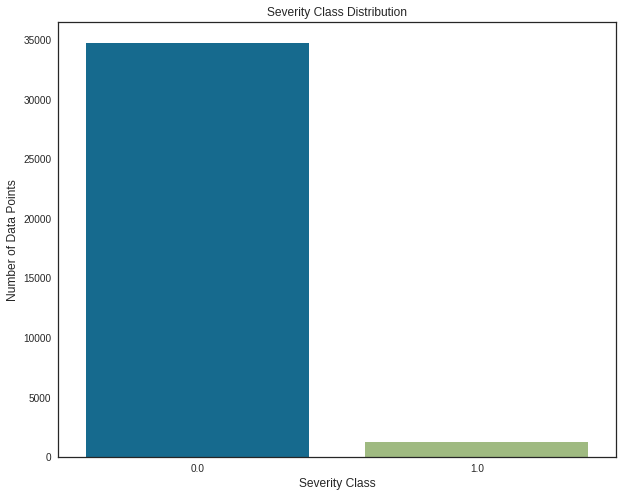

In [ ]:
plt.figure(figsize=(10,8))
ax = sns.countplot(data = crashweather, x = "Crash Severity")
plt.title("Severity Class Distribution")
plt.ylabel('Number of Data Points', fontsize=12)
plt.xlabel('Severity Class', fontsize=12)

## Crash Timeline

#### Yearly Crash Distribution

Text(0.5, 0, 'Year')

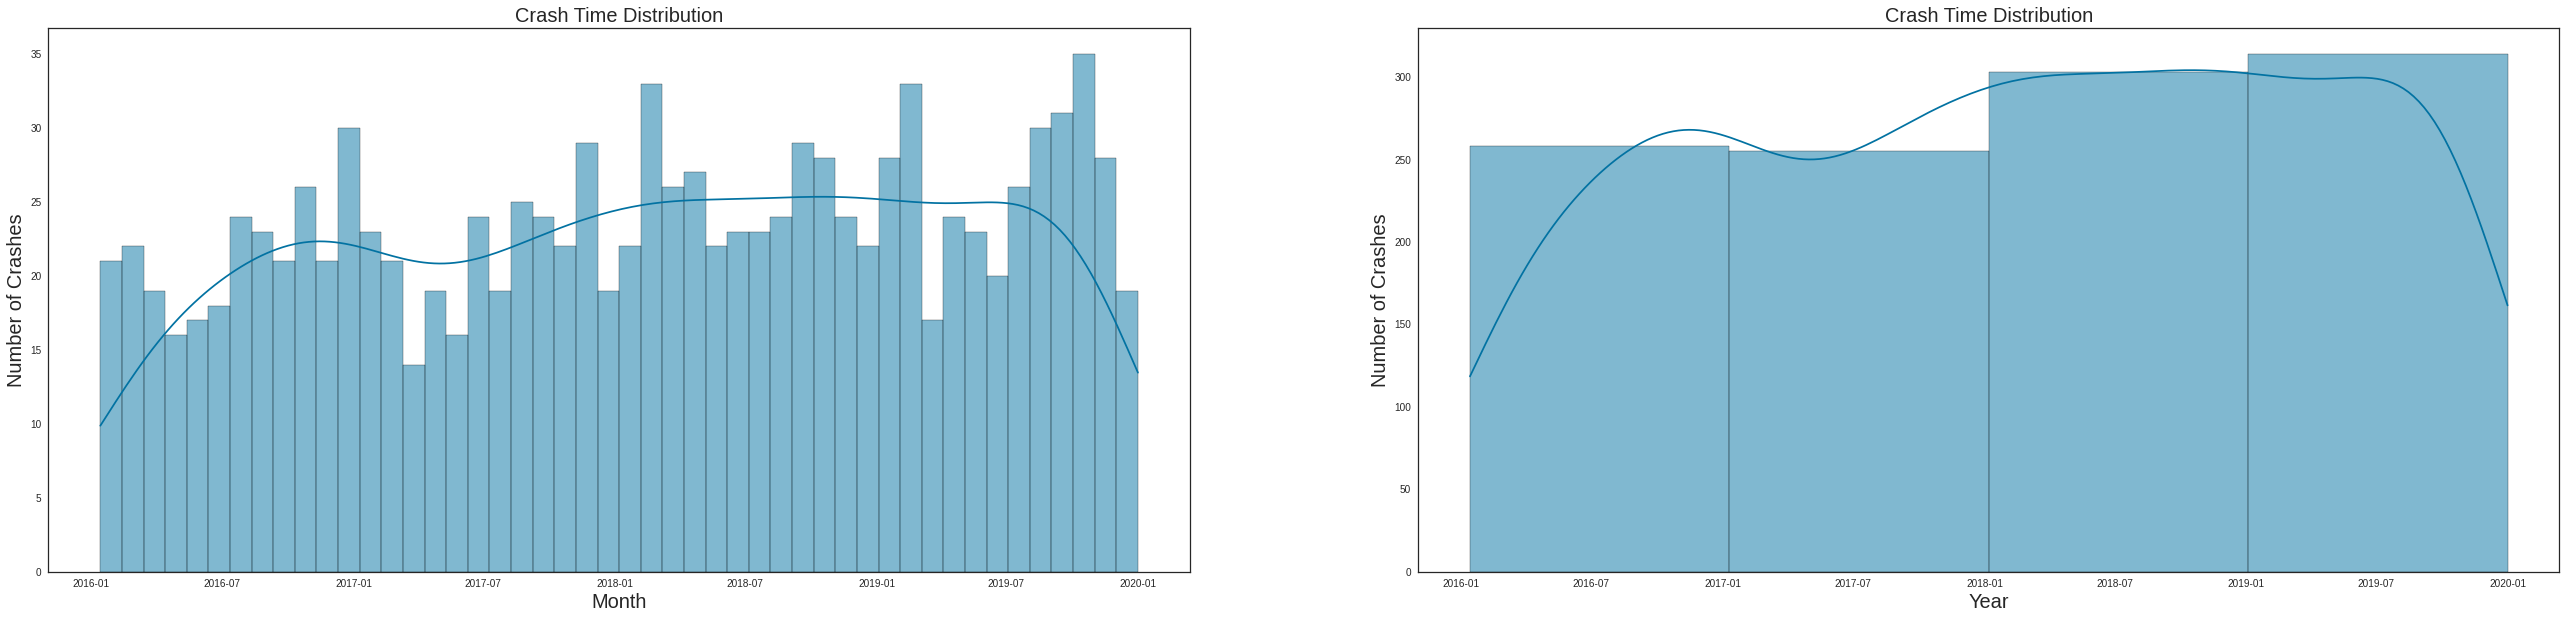

In [ ]:
#visualizing timeline of accidents recroded by month
f, axs = plt.subplots(2,2,figsize=(45,10))


timeline = EDAcrash.groupby('date_time').count().reset_index()

plt.subplot(1,2,1)
axs = sns.histplot(data = timeline, x = "date_time", kde = True, bins = 48)
#bin = 60 is hardcoded # of months in the crash data set (5 years)
plt.title("Crash Time Distribution",fontsize=20)
plt.ylabel('Number of Crashes', fontsize=20)
plt.xlabel('Month', fontsize=20)

plt.subplot(1,2,2)
axs = sns.histplot(data = timeline, x = "date_time", kde = True, bins = 4)
#bin = 60 is hardcoded # of months in the crash data set (5 years)
plt.title("Crash Time Distribution",fontsize=20)
plt.ylabel('Number of Crashes', fontsize=20)
plt.xlabel('Year', fontsize=20)

#### Hourly Crash Distribution

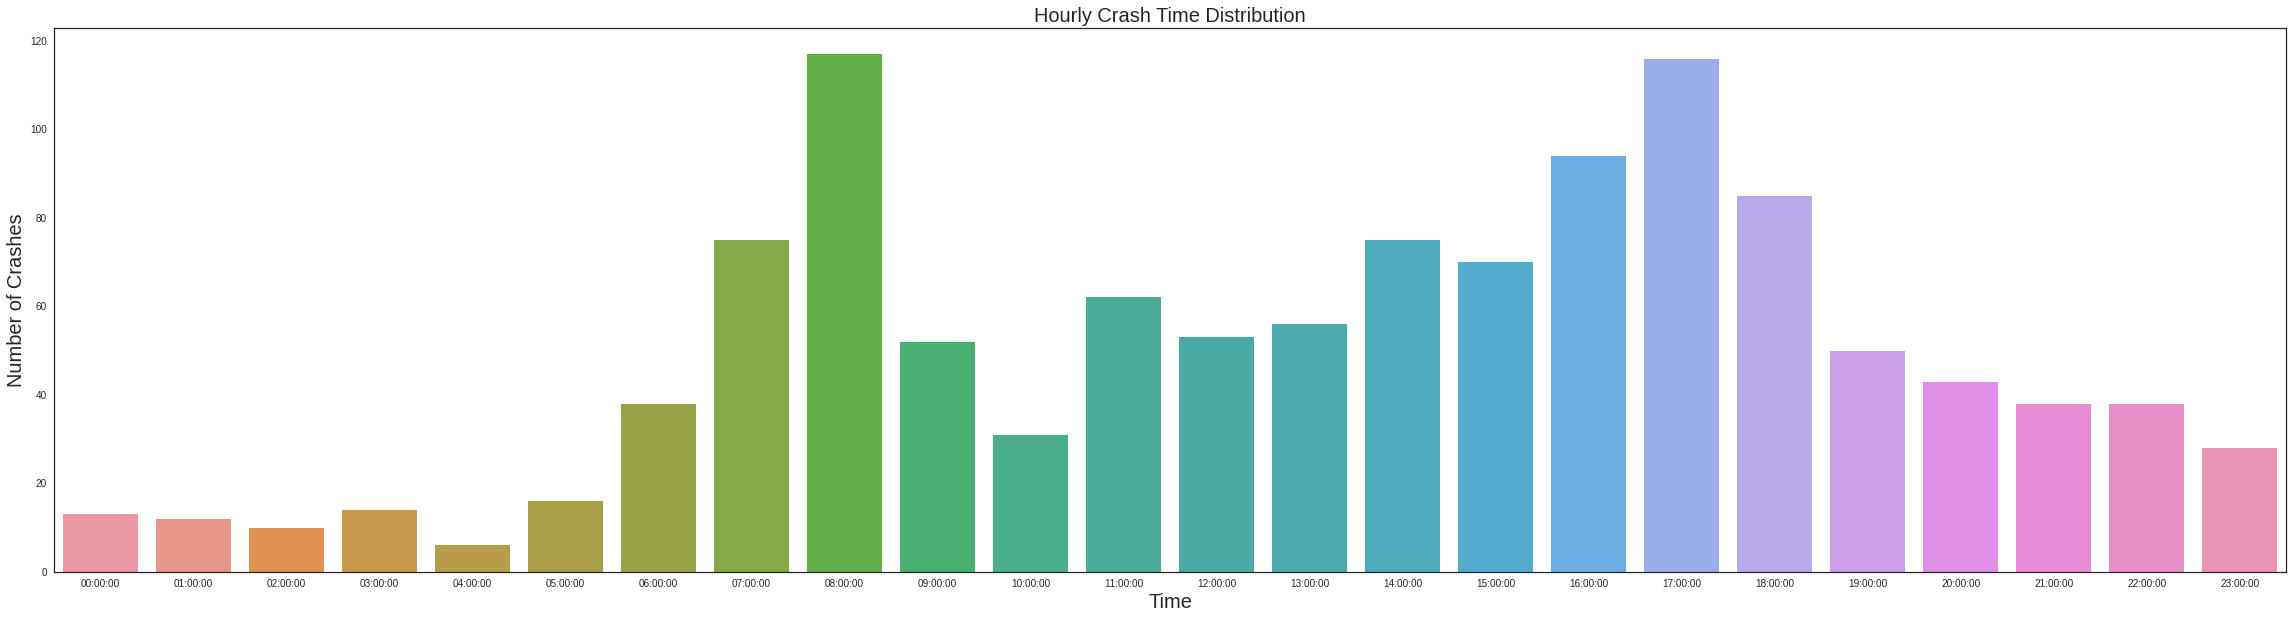

In [ ]:
#groupby hour increments 
hourly = EDAcrash.groupby(EDAcrash.date_time.dt.time).count()



plt.figure(figsize=(40,10))
axs = sns.barplot(x = hourly.index, y = 'date_time', data = hourly)
plt.title("Hourly Crash Time Distribution",fontsize=20)
plt.ylabel('Number of Crashes', fontsize=20)
plt.xlabel('Time', fontsize=20)


plt.show()

#### Daily Crash Distribution

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



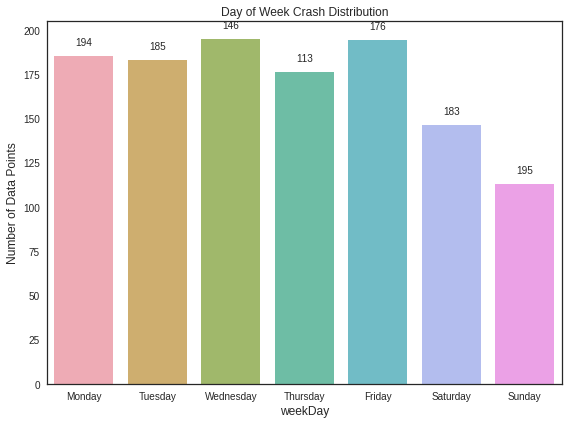

In [ ]:
daily = EDAcrash.copy()
daily['weekday'] = daily['date_time'].dt.day_name()

a = daily['weekday'].value_counts()
a = a.sort_index()

# plot
plt.figure(figsize=(8,6))
ax= sns.barplot(a.index, a.values, alpha=0.8, order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Day of Week Crash Distribution")
plt.ylabel('Number of Data Points', fontsize=12)
plt.xlabel('weekDay', fontsize=12)

# adding the text labels
rects = ax.patches
labels = a.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### Seasonal Crash Distribution

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



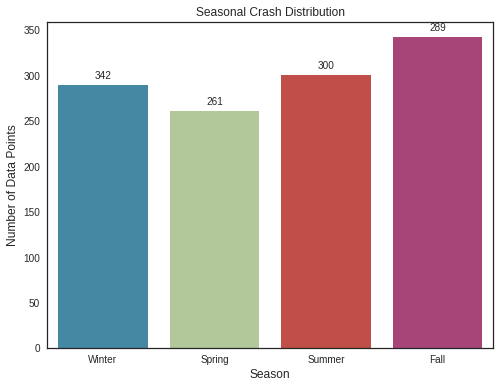

In [ ]:
season= EDAcrash.copy()
season['Season'] = season['date_time'].dt.month%12 // 3 + 1 #math operation to catagorize month into season

season.loc[season["Season"] == 1, 'Season'] = 'Winter'
season.loc[season["Season"] == 2, 'Season'] = 'Spring'
season.loc[season["Season"] == 3, 'Season'] = 'Summer'
season.loc[season["Season"] == 4, 'Season'] = 'Fall'

a = season['Season'].value_counts()
a = a.sort_index()

# plot
plt.figure(figsize=(8,6))
ax= sns.barplot(a.index, a.values, alpha=0.8, order = ['Winter','Spring', 'Summer', 'Fall'])
plt.title("Seasonal Crash Distribution")
plt.ylabel('Number of Data Points', fontsize=12)
plt.xlabel('Season', fontsize=12)

# adding the text labels
rects = ax.patches
labels = a.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

## Weather Distribution

#### General Distribution

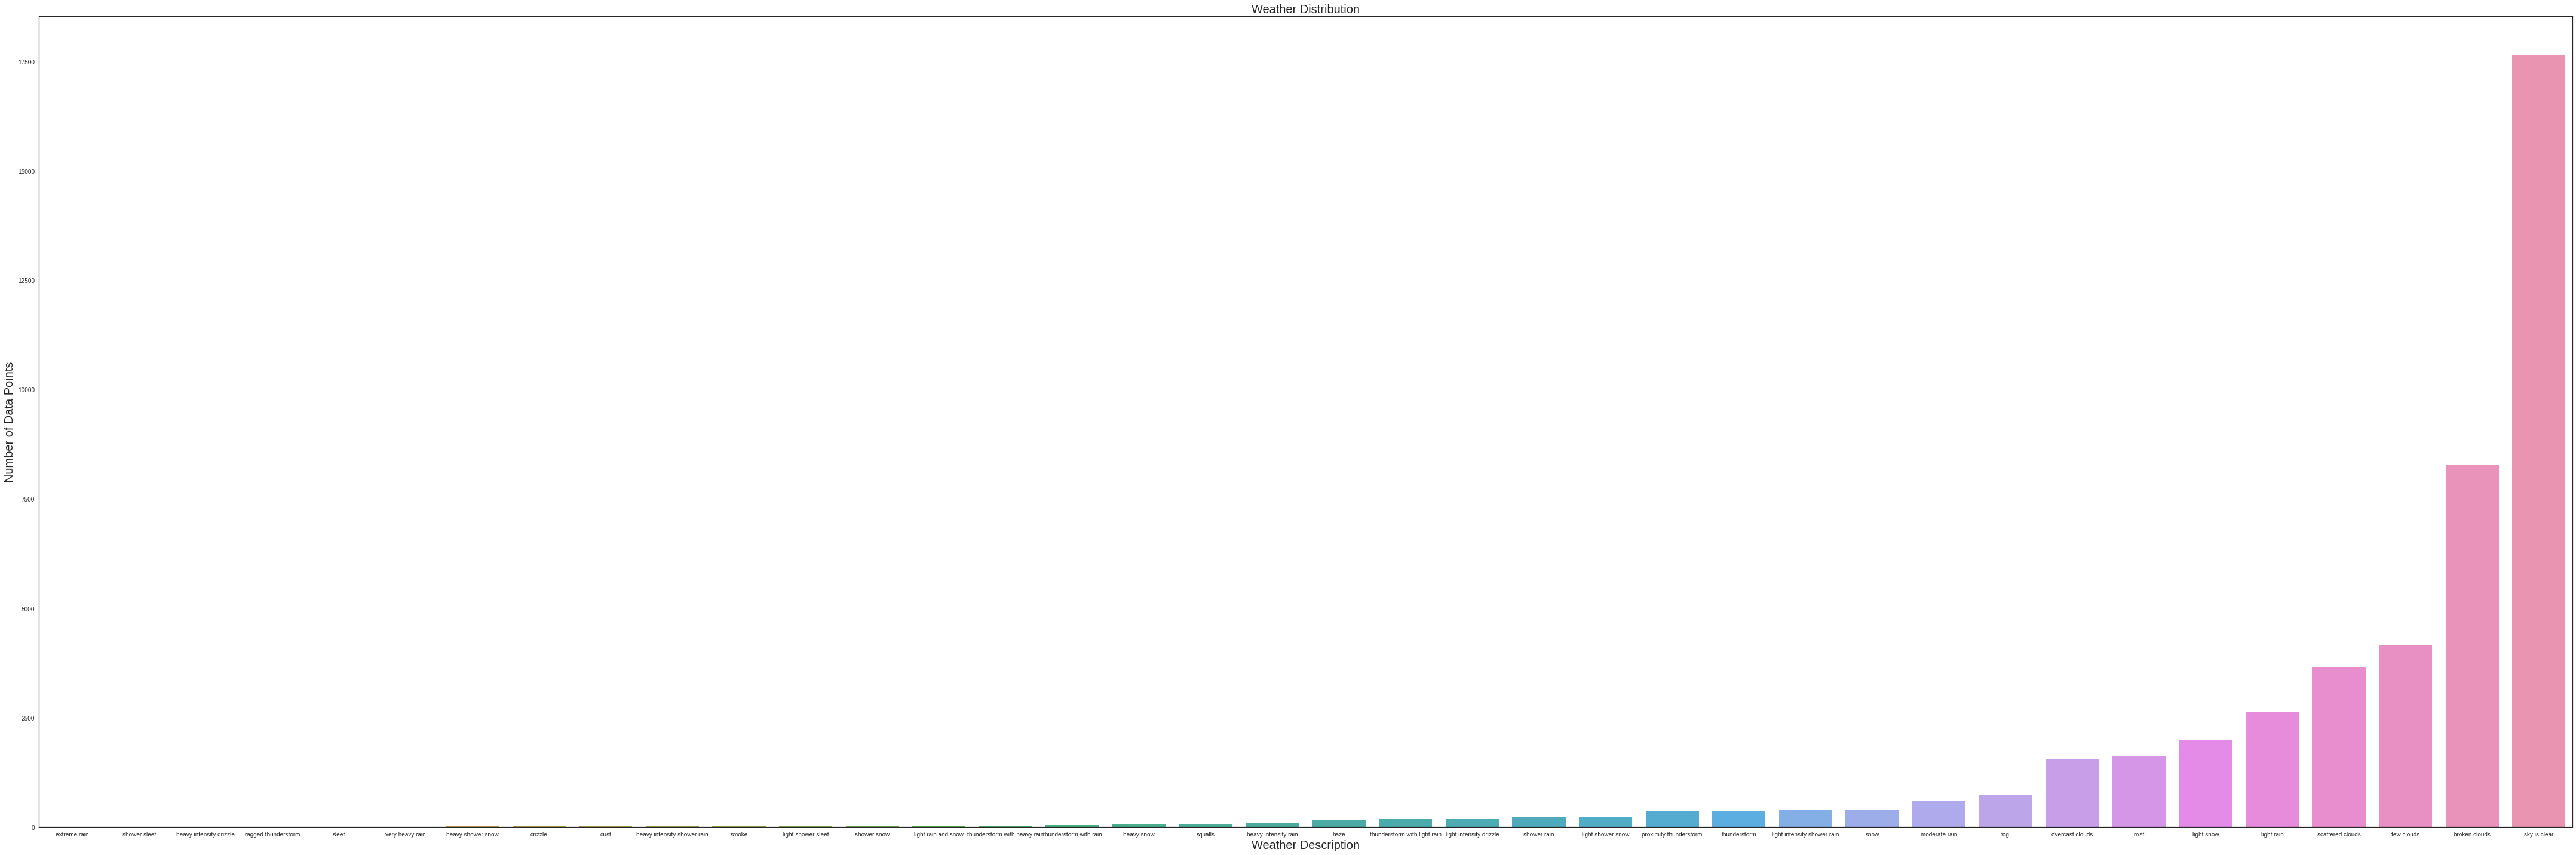

In [ ]:
weatherdist = EDAweather.groupby(EDAweather.weather_description).count()
weatherdist = weatherdist['dt_iso'] 
weatherdist = weatherdist.reset_index()


plt.figure(figsize=(60,20))
axs = sns.barplot(x = 'weather_description', y = 'dt_iso', data = weatherdist,order = weatherdist.sort_values('dt_iso').weather_description)
plt.title("Weather Distribution",fontsize=20)
plt.ylabel('Number of Data Points', fontsize=20)
plt.xlabel('Weather Description', fontsize=20)

plt.tight_layout()

#### Weather Distribution in Crash Classes

In [ ]:
EDAweather = EDAweather.set_index("dt_iso")

EDAcrashweather = EDAweather.join(crash, how = 'outer')

#weather without a corresponding crash data point have nulls in the crash severity. Fill w/0 for the 'No accident' class
EDAcrashweather = EDAcrashweather.fillna(value = 0)


##### Weather in Crash

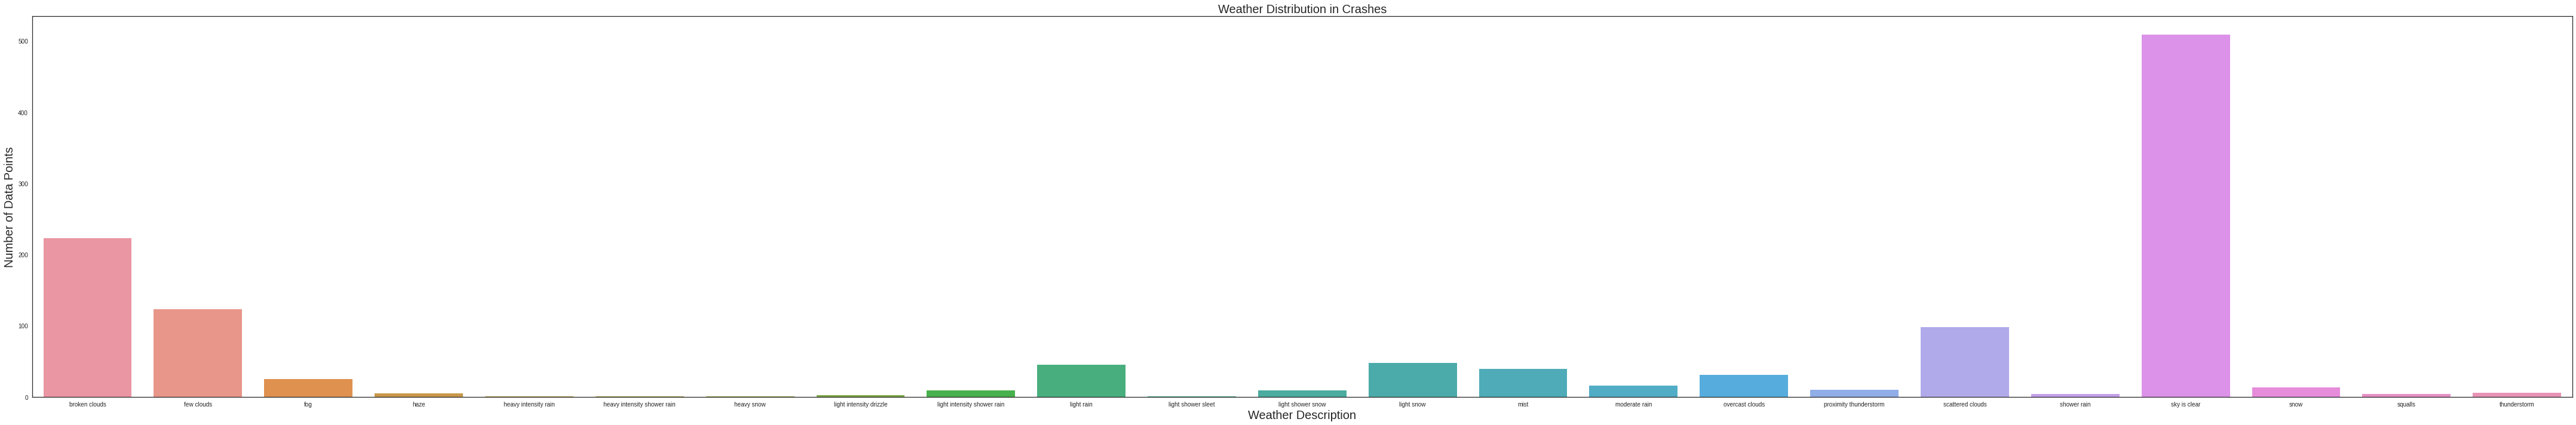

In [ ]:
EDAcrashweather1 = EDAcrashweather[EDAcrashweather['Crash Severity'] != 0 ]
weatherdist = EDAcrashweather1.groupby(EDAcrashweather1.weather_description).count()
weatherdist = weatherdist['temp'] 
weatherdist = weatherdist.reset_index()


plt.figure(figsize=(60,10))
axs = sns.barplot(x = 'weather_description', y = 'temp', data = weatherdist)
plt.title("Weather Distribution in Crashes",fontsize=20)
plt.ylabel('Number of Data Points', fontsize=20)
plt.xlabel('Weather Description', fontsize=20)

plt.tight_layout()

##### Weather in No Crash

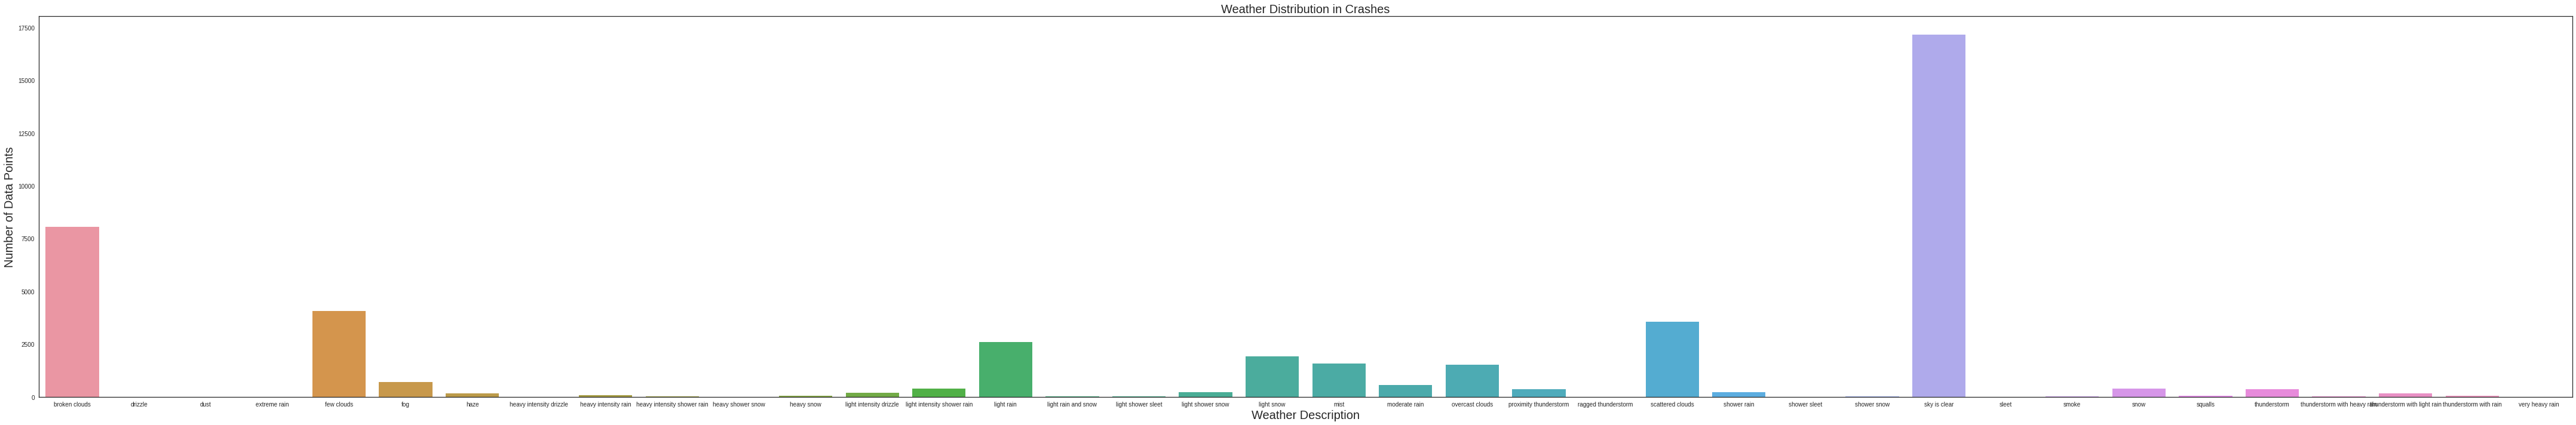

In [ ]:
EDAcrashweather0 = EDAcrashweather[EDAcrashweather['Crash Severity'] == 0 ]
weatherdist = EDAcrashweather0.groupby(EDAcrashweather0.weather_description).count()
weatherdist = weatherdist['temp'] 
weatherdist = weatherdist.reset_index()


plt.figure(figsize=(60,10))
axs = sns.barplot(x = 'weather_description', y = 'temp', data = weatherdist)
plt.title("Weather Distribution in Crashes",fontsize=20)
plt.ylabel('Number of Data Points', fontsize=20)
plt.xlabel('Weather Description', fontsize=20)

plt.tight_layout()

In [ ]:
EDAc

#### Heatmaps

##### Crashes Across a week 

In [ ]:
table = pd.pivot_table(daily,index=[daily['date_time'].dt.hour],columns=['weekday'],values=['weekday'],aggfunc=['count'],fill_value=0)


table.columns = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
table = table[order]

plt.figure(figsize=(15,10))
plt.title("Crash Time Heatmap",fontsize=20)
sns.heatmap(data=table, cmap="RdBu_r", linewidths=0.1, center = 15) 

##### Crash and Weather Pearson Colinearity

In [ ]:
!pip install heatmapz
from heatmap import heatmap, corrplot

data = crashweather
plt.figure(figsize=(10, 10))
corrplot(data.corr(), size_scale=200)

### Weather Crash Correlation

In [ ]:
EDAcrashweather_corr = EDAcrashweather[['weather_description','Crash Severity']]

EDAcrashweather_corr.loc[EDAcrashweather_corr['Crash Severity'] == 1.0, 'Crash'] = 1
EDAcrashweather_corr.loc[EDAcrashweather_corr['Crash Severity'] == 0.0, 'No Crash'] = 1

df_pivot_weather = pd.pivot_table(EDAcrashweather_corr,index=['weather_description'], values=['Crash', 'No Crash'], aggfunc= ['sum'])
df_pivot_weather.columns = df_pivot_weather.columns.droplevel(0)
df_pivot_weather = df_pivot_weather.reset_index()

df_pivot_weather.set_index(["weather_description"], inplace=True)

df_pivot_weather = df_pivot_weather.div(df_pivot_weather.sum(axis=1), axis=0)
df_pivot_weather = df_pivot_weather.sort_values(by = 'Crash', ascending = False)

data = df_pivot_weather.copy()
data['No Crash'] = data['No Crash'].apply(lambda x: '%.0f%%' % (x*100))
data['Crash'] = data['Crash'].apply(lambda x: '%.0f%%' % (x*100))   

data


# Train Test Split

In [ ]:
y = crashweather['Crash Severity']
X = crashweather.drop('Crash Severity', axis = 1)

#normalize data
scaler = StandardScaler()
x = scaler.fit_transform(X.values)
x = pd.DataFrame(x, index=X.index, columns=X.columns)


x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                    test_size=0.3,
                                                    random_state=0)


### Distribution in Train Test Split

In [ ]:
f, axs = plt.subplots(2,2,figsize=(20,10))

plt.subplot(1,2,1)
sns.histplot(data = y_train, bins = 2)
plt.xticks([0,1])
plt.title("Severity Distribution in Train data",fontsize=20)
plt.ylabel('Number of Crashes', fontsize=20)
plt.xlabel('Severity', fontsize=20)

plt.subplot(1,2,2)
sns.histplot(data = y_test, bins = 2)
plt.xticks([0,1])
plt.title("Severity Distribution in Test data",fontsize=20)
plt.ylabel('Number of Crashes', fontsize=20)
plt.xlabel('Severity', fontsize=20)

# Model Selection

In [ ]:
# DecisionTree Model
DT = DecisionTreeClassifier()
DT.fit(x_train,y_train)

# RandomForest Model
RF = RandomForestClassifier()
RF.fit(x_train,y_train)

# XGBoost Model 
XGB = XGBClassifier()
XGB.fit(x_train,y_train)

# KNeighbors Model
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

### lgbm
lgbm = lgb.LGBMClassifier()
lgbm.fit(x_train, y_train)

###logit Regression
logreg = LogisticRegression( max_iter=100000, random_state=0)
logreg.fit(x_train, y_train)

models = [DT, knn, RF,XGB, lgbm, logreg]

names = ['DT', "knn", "RF", "XGB", "lgbm",'logit']
evaluates = ['accuracy','precision','recall','f1','auc']

df_list = []
for name, model in zip(names, models):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # accuracy
    train_accuracy = model.score(x_train, y_train)
    test_accuracy = model.score(x_test, y_test)
    # precision
    train_precision = precision_score(y_train, y_train_pred, average = 'weighted')
    test_precision = precision_score(y_test, y_test_pred, average = 'weighted')
    # recall
    train_recall = recall_score(y_train, y_train_pred, average = 'weighted')
    test_recall = recall_score(y_test, y_test_pred, average = 'weighted')
    # f1
    train_f1 = f1_score(y_train, y_train_pred, average = 'weighted')
    test_f1 = f1_score(y_test, y_test_pred, average = 'weighted')


    train_auc = roc_auc_score(y_train, y_train_pred, multi_class = 'ovr')
    test_auc = roc_auc_score(y_test, y_test_pred, multi_class = 'ovr')
    print('{}  Train Data： accuracy:{:.3}, precision:{:.3}, recall:{:.3}, f1:{:.3}, auc:{:.3}'.format(name, train_accuracy,
                                                                                              train_precision,
                                                                                              train_recall, train_f1,
                                                                                              train_auc))
    print('{}  Test Data： accuracy:{:.3}, precision:{:.3}, recall:{:.3}, f1:{:.3}, auc:{:.3}'.format(name, test_accuracy,
                                                                                              test_precision,
                                                                                              test_recall, test_f1,
                                                                                              test_auc))
    print('\n')
    df = pd.DataFrame(np.array(
        [train_accuracy, train_precision, train_recall, train_f1, train_auc, test_accuracy, test_precision, test_recall,
         test_f1, test_auc]).reshape(2, -1),
                      index=['train', 'test'],
                      columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-Score'])
    df_list.append(df)

result = pd.concat(df_list, axis=0, keys=names)
result[:]

# Random Forest Classifier

In [ ]:
clf = RandomForestClassifier(random_state=0)
clf.fit(x_train, y_train)
print(classification_report(y_test, clf.predict(x_test)))

cv_scores = cross_val_score(clf, x_train, y_train, cv=10)
print("Accuracy of %0.2f, with a standard deviation of %0.2f" % (cv_scores.mean(), cv_scores.std()))

## Confusion Matirx

In [ ]:
y_pred = clf.predict(x_test)

cm_crash = confusion_matrix(y_test,y_pred)
display_cm_crash = ConfusionMatrixDisplay(confusion_matrix=cm_crash)
display_cm_crash.plot()

## Feature Importance

In [ ]:
def plot_feature_importance(importance,names,model_type):
  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,15))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

plot_feature_importance(clf.feature_importances_,x.columns,'RANDOM FOREST')

#Log Reg

## Coef display

In [ ]:
logreg = LogisticRegression( max_iter=100000, random_state=0)
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

print("Training set score: {:.3f}".format(logreg.score(x_train,y_train)))
print("Test set score: {:.3f}".format(logreg.score(x_test,y_test)))

coef_list = logreg.coef_.tolist()[0]
feature_names = list(x.columns)
coefdf = pd.DataFrame({'feature_names':feature_names, 'coef':coef_list})
print(coefdf)

## Confusion Matrix

In [ ]:
cm_crash = confusion_matrix(y_test,y_pred)
display_cm_crash = ConfusionMatrixDisplay(confusion_matrix=cm_crash)
display_cm_crash.plot()